In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [3]:
# let's start with the super useful intro on how to extract a BED file with gene annotation from HiGlass docs ...
# https://docs.higlass.io/data_preparation.html#gene-annotation-tracks

In [4]:
ASSEMBLY="hg19"
TAXID=9606
DATADIR="./gene_annot_data"


### let's download some refseq, gene info and stuff

In [5]:
# %%bash
# DATADIR=./gene_annot_data
# mkdir -p $DATADIR
# mkdir -p $DATADIR/genbank
# wget -N -P $DATADIR ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2refseq.gz
# wget -N -P $DATADIR ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene_info.gz
# wget -N -P $DATADIR ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2pubmed.gz


--2021-03-25 16:38:05--  ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2refseq.gz
           => ‘./gene_annot_data/.listing’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.13, 2607:f220:41f:250::228, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gene/DATA ... done.
==> PASV ... done.    ==> LIST ... done.

     0K .                                                       171K=0.009s

2021-03-25 16:38:06 (171 KB/s) - ‘./gene_annot_data/.listing’ saved [1601]

Removed ‘./gene_annot_data/.listing’.
--2021-03-25 16:38:06--  ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2refseq.gz
           => ‘./gene_annot_data/gene2refseq.gz’
==> CWD not required.
==> PASV ... done.    ==> RETR gene2refseq.gz ... done.
Length: 1028166334 (981M)

     0K .......... .......... .......... .......... ..........  0%  388K 43m6

## Download data from UCSC and NCBI

In [18]:
%%bash -s "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# Download UCSC refGene database for assembly of interest
mkdir $DATADIR/$ASSEMBLY
wget -N -P $DATADIR/$ASSEMBLY/ http://hgdownload.cse.ucsc.edu/goldenPath/$ASSEMBLY/database/refGene.txt.gz

# Filter genbank data for species of interest
zcat $DATADIR/gene2refseq.gz | grep ^${TAXID} > $DATADIR/$ASSEMBLY/gene2refseq
zcat $DATADIR/gene_info.gz | grep ^${TAXID} | sort -k 2 > $DATADIR/$ASSEMBLY/gene_info # gene-centric
zcat $DATADIR/gene2pubmed.gz | grep ^${TAXID} > $DATADIR/$ASSEMBLY/gene2pubmed

# Sort
# Optional: filter out unplaced and unlocalized scaffolds (which have a "_" in the chrom name)
zcat $DATADIR/$ASSEMBLY/refGene.txt.gz \
    | awk -F $'\t' '{if (!($3 ~ /_/)) print;}' \
    | sort -k 2 \
    > $DATADIR/$ASSEMBLY/refGene_sorted
# not a BED-looking file - gene centric

--2021-03-25 16:49:11--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/database/refGene.txt.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8043766 (7.7M) [application/x-gzip]
Saving to: ‘./gene_annot_data/hg19/refGene.txt.gz’

     0K .......... .......... .......... .......... ..........  0%  279K 28s
    50K .......... .......... .......... .......... ..........  1%  566K 21s
   100K .......... .......... .......... .......... ..........  1% 15.7M 14s
   150K .......... .......... .......... .......... ..........  2% 16.2M 10s
   200K .......... .......... .......... .......... ..........  3%  584K 11s
   250K .......... .......... .......... .......... ..........  3% 8.85M 9s
   300K .......... .......... .......... .......... ..........  4% 36.5M 8s
   350K .......... .......... .......... ......

In [123]:
!cat ./gene_annot_data/hg19/refGene_sorted | grep CXXC5 

1645	NM_001317199	chr5	+	139027933	139063467	139060108	139062492	4	139027933,139059431,139059948,139062447,	139028430,139059525,139061032,139063467,	0	CXXC5	cmpl	cmpl	-1,-1,0,0,
1645	NM_001317200	chr5	+	139028535	139063467	139060108	139062492	3	139028535,139059948,139062447,	139028594,139061032,139063467,	0	CXXC5	cmpl	cmpl	-1,0,0,
1645	NM_001317201	chr5	+	139026883	139063470	139060108	139062492	3	139026883,139059948,139062447,	139027020,139061032,139063470,	0	CXXC5	cmpl	cmpl	-1,0,0,
1645	NM_001317202	chr5	+	139027488	139063470	139060108	139062492	3	139027488,139059948,139062447,	139027589,139061032,139063470,	0	CXXC5	cmpl	cmpl	-1,0,0,
1645	NM_001317203	chr5	+	139028535	139063467	139060108	139062492	4	139028535,139045164,139059948,139062447,	139028594,139045388,139061032,139063467,	0	CXXC5	cmpl	cmpl	-1,-1,0,0,
1645	NM_001317204	chr5	+	139028535	139063467	139060108	139062492	4	139028535,139059431,139059948,139062447,	139028594,139059525,139061032,139063467,	0	CXXC5	cmpl	cmpl	-1,-1,0,0,
1

In [120]:
!cat ./gene_annot_data/hg19/refGene_sorted | grep UBE2D2

1645	NM_003339	chr5	+	138940923	139008018	138941376	139006386	7	138940923,138979956,138994170,138994281,138994445,139002952,139006340,	138941400,138980020,138994202,138994359,138994551,139003046,139008018,	0	UBE2D2	cmpl	cmpl	0,0,1,0,0,1,2,
1645	NM_181838	chr5	+	138940750	139008018	138980019	139006386	8	138940750,138941828,138979956,138994170,138994281,138994445,139002952,139006340,	138941400,138941992,138980020,138994202,138994359,138994551,139003046,139008018,	0	UBE2D2	cmpl	cmpl	-1,-1,0,1,0,0,1,2,


In [131]:
!cat ./gene_annot_data/hg19/geneid_refGene_count

100008586	NM_001098405	chrX	+	49296745	49304144	49297934	49304050	5	49296745,49297926,49298483,49301426,49304027,	49296887,49298018,49298604,49301552,49304144,	3
100008586	NM_001098405	chrX	+	49306301	49313700	49307490	49313606	5	49306301,49307482,49308039,49310982,49313583,	49306443,49307574,49308160,49311108,49313700,	3
100008586	NM_001098405	chrX	+	49315857	49323252	49317046	49323158	5	49315857,49317038,49317595,49320538,49323135,	49315999,49317130,49317716,49320664,49323252,	3
100008586	NM_001098405	chrX	+	49325410	49332811	49326599	49332717	5	49325410,49326591,49327148,49330097,49332694,	49325552,49326683,49327269,49330223,49332811,	3
100008586	NM_001098405	chrX	+	49334968	49342360	49336157	49342266	5	49334968,49336149,49336706,49339650,49342243,	49335110,49336241,49336827,49339776,49342360,	3
100009613	NR_103835	chr11	-	69918539	69921454	69921454	69921454	3	69918539,69921041,69921427,	69919045,69921312,69921454,	1
100009667	NR_131184	chr10	-	69769703	69770640	69770640	69770640	1	

100616483	NR_039906	chr19	+	50436320	50436394	50436394	50436394	1	50436320,	50436394,	2
100616484	NR_039680	chr8	+	62627346	62627418	62627418	62627418	1	62627346,	62627418,	4
100616485	NR_039649	chr3	-	116569123	116569214	116569214	116569214	1	116569123,	116569214,	2
100616486	NR_039847	chr12	+	47581594	47581674	47581674	47581674	1	47581594,	47581674,	3
100616487	NR_039742	chr16	+	28969903	28969982	28969982	28969982	1	28969903,	28969982,	3
100616488	NR_039699	chr10	-	12172758	12172815	12172815	12172815	1	12172758,	12172815,	2
100616490	NR_039855	chr14	+	65511405	65511487	65511487	65511487	1	65511405,	65511487,	3
100616491	NR_039774	chrX	+	109325345	109325446	109325446	109325446	1	109325345,	109325446,	4
100616492	NR_039615	chr1	+	24255559	24255637	24255637	24255637	1	24255559,	24255637,	3
100616493	NR_039643	chr2	-	240007522	240007622	240007622	240007622	1	240007522,	240007622,	2
100616494	NR_039747	chr17	-	12820584	12820659	12820659	12820659	1	12820584,	12820659,	4
100616495	NR_039729

103352539	NR_121647	chr9	+	66457288	66469310	66469310	66469310	5	66457288,66459807,66465591,66467762,66468616,	66457355,66459964,66467413,66467899,66469310,	5
103352541	NR_121624	chr6	-	140299486	140312398	140312398	140312398	3	140299486,140299758,140312129,	140299541,140300010,140312398,	1
103352670	NR_122034	chr8	+	84315992	84321132	84321132	84321132	2	84315992,84319926,	84316304,84321132,	1
10336	NM_001317836	chr4	+	699620	764768	727469	759867	12	699620,724418,724758,726188,727460,728719,731254,737261,738387,755066,758771,759819,	699759,724457,724899,726287,727578,728816,731310,737372,738476,755204,758852,764768,	32
10336	NM_006315	chr4	+	699620	764768	727469	759867	11	699620,724418,724758,727460,728719,731254,737261,738387,755066,758771,759819,	699759,724457,724899,727578,728816,731310,737372,738476,755204,758852,764768,	32
10342	NM_001007565	chr3	+	100428133	100467811	100432529	100467375	8	100428133,100432486,100438818,100447555,100451351,100455419,100463676,100466992,	100428275,1

10856	NM_001321190	chr19	+	49497143	49519227	49507512	49519099	15	49497143,49502575,49506535,49507463,49510274,49510558,49513032,49513229,49513744,49514255,49514448,49517740,49518277,49518828,49519073,	49497180,49502630,49506591,49507675,49510404,49510625,49513139,49513323,49513868,49514350,49514567,49517860,49518407,49518943,49519227,	295
10856	NM_001321191	chr19	+	49496704	49519252	49507545	49519099	15	49496704,49502575,49506535,49507533,49510274,49510558,49513032,49513229,49513744,49514255,49514448,49517740,49518277,49518828,49519073,	49497159,49502630,49506591,49507675,49510404,49510625,49513139,49513323,49513868,49514350,49514567,49517860,49518407,49518943,49519252,	295
10856	NM_006666	chr19	+	49497143	49519227	49497168	49519099	15	49497143,49502575,49506535,49507533,49510274,49510558,49513032,49513229,49513744,49514255,49514448,49517740,49518277,49518828,49519073,	49497180,49502630,49506591,49507675,49510404,49510625,49513139,49513323,49513868,49514350,49514567,49517860,49518407,

114899	NR_146599	chr5	-	34017962	34244829	34244829	34244829	12	34017962,34024013,34028858,34033408,34035751,34169131,34175549,34175926,34179117,34182784,34218399,34244720,	34020847,34024113,34028988,34033563,34035863,34169258,34175642,34176062,34179202,34182972,34218555,34244829,	55
114900	NM_031909	chr11	-	47611218	47615963	47611372	47612362	2	47611218,47615699,	47612367,47615963,	7
114902	NM_001278431	chr11	-	119209651	119211593	119210040	119211107	3	119209651,119210893,119211404,	119210558,119211150,119211593,	47
114902	NM_015645	chr11	-	119209651	119217415	119210040	119211107	15	119209651,119210893,119211404,119212566,119213305,119213582,119214525,119215024,119215341,119215583,119216129,119216482,119216755,119216981,119217169,	119210558,119211150,119212482,119212694,119213437,119213713,119214674,119215101,119215467,119215714,119216343,119216638,119216869,119217084,119217415,	47
114904	NM_001365878	chr22	-	37576205	37595463	37578227	37581489	5	37576205,37581257,37586904,37593642,375

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Get full model and citation count for each gene

In [21]:
%%bash -s  "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# Count pubmed citations
# Output: {gene_id} \t {citation_count}
cat $DATADIR/$ASSEMBLY/gene2pubmed \
    | awk '{print $2}' \
    | sort \
    | uniq -c \
    | awk '{print $2 "\t" $1}' \
    | sort \
    > $DATADIR/$ASSEMBLY/gene2pubmed-count

# Gene2refseq dictionary
# Output: {gene_id} \t {refseq_id}
cat $DATADIR/$ASSEMBLY/gene2refseq \
    | awk -F $'\t' '{ split($4,a,"."); if (a[1] != "-") print $2 "\t" a[1];}' \
    | sort \
    | uniq  \
    > $DATADIR/$ASSEMBLY/geneid_refseqid

# Append refseq IDs to citation count table
# Output: {gene_id} \t {refseq_id} \t {citation_count}
join $DATADIR/$ASSEMBLY/geneid_refseqid \
    $DATADIR/$ASSEMBLY/gene2pubmed-count  \
    | sort -k2 \
    > $DATADIR/$ASSEMBLY/geneid_refseqid_count

# Join the refseq gene model against gene IDs
# Output: {gene_id} \t {refseq_id} \t {chrom}(5) \t {strand}(6) \t {txStart}(7) \t {txEnd}(8) \t {cdsStart}(9) \t {cdsEnd}(10) \t {exonCount}(11) \t {exonStarts}(12) \t {exonEnds}(13)
join -1 2 -2 2 \
    $DATADIR/$ASSEMBLY/geneid_refseqid_count \
    $DATADIR/$ASSEMBLY/refGene_sorted \
    | awk '{ print $2 "\t" $1 "\t" $5 "\t" $6 "\t" $7 "\t" $8 "\t" $9 "\t" $10 "\t" $11 "\t" $12 "\t" $13 "\t" $3; }' \
    | sort -k1   \
    > $DATADIR/$ASSEMBLY/geneid_refGene_count

# Join citation counts against gene information
# output -> geneid \t symbol \t gene_type \t name \t citation_count
join -1 2 -2 1 -t $'\t' \
    $DATADIR/$ASSEMBLY/gene_info \
    $DATADIR/$ASSEMBLY/gene2pubmed-count \
    | awk -F $'\t' '{print $1 "\t" $3 "\t" $10 "\t" $12 "\t" $16}' \
    | sort -k1 \
    > $DATADIR/$ASSEMBLY/gene_subinfo_citation_count


join: ./gene_annot_data/hg19/geneid_refseqid:8: is not sorted: 10000	NM_001206729
join: ./gene_annot_data/hg19/gene2pubmed-count:94: is not sorted: 1000	345
join: input is not in sorted order
join: ./gene_annot_data/hg19/geneid_refseqid_count:554: is not sorted: 6166 NM_001001 44
join: ./gene_annot_data/hg19/refGene_sorted:1117: is not sorted: 967	NM_001001	chr14	-	50085247	50087344	50085501	50085822	2	50085247,50087279,	50085858,50087344,	0	RPL36AL	cmpl	cmpl	0,-1,
join: input is not in sorted order
join: ./gene_annot_data/hg19/gene_info:19: is not sorted: 9606	10000	AKT3	-	MPPH|MPPH2|PKB-GAMMA|PKBG|PRKBG|RAC-PK-gamma|RAC-gamma|STK-2	MIM:611223|HGNC:HGNC:393|Ensembl:ENSG00000117020	1	1q43-q44	AKT serine/threonine kinase 3	protein-coding	AKT3	AKT serine/threonine kinase 3	O	RAC-gamma serine/threonine-protein kinase|PKB gamma|RAC-gamma serine/threonine protein kinase|v-akt murine thymoma viral oncogene homolog 3 (protein kinase B, gamma)	20210302	-
join: ./gene_annot_data/hg19/gene2pubme

In [85]:
# !wget https://raw.githubusercontent.com/higlass/clodius/develop/scripts/exonU.py

In [24]:
%%bash -s  "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# 1: chr (chr1)
# 2: txStart (52301201) [9]
# 3: txEnd (52317145) [10]
# 4: geneName (ACVRL1)   [2]
# 5: citationCount (123) [16]
# 6: strand (+)  [8]
# 7: refseqId (NM_000020)
# 8: geneId (94) [1]
# 9: geneType (protein-coding)
# 10: geneDesc (activin A receptor type II-like 1)
# 11: cdsStart (52306258)
# 12: cdsEnd (52314677)
# 13: exonStarts (52301201,52306253,52306882,52307342,52307757,52308222,52309008,52309819,52312768,52314542,)
# 14: exonEnds (52301479,52306319,52307134,52307554,52307857,52308369,52309284,52310017,52312899,52317145,)
join -t $'\t' \
    $DATADIR/$ASSEMBLY/gene_subinfo_citation_count \
    $DATADIR/$ASSEMBLY/geneid_refGene_count \
    | awk -F $'\t' '{print $7 "\t" $9 "\t" $10 "\t" $2 "\t" $16 "\t" $8 "\t" $6 "\t" $1 "\t" $3 "\t" $4 "\t" $11 "\t" $12 "\t" $14 "\t" $15}' \
    > $DATADIR/$ASSEMBLY/geneAnnotations.bed

# Download: https://raw.githubusercontent.com/higlass/clodius/develop/scripts/exonU.py
# ! scp ghpcc:/nl/umw_job_dekker/cshare/reference/sorted_chromsizes/hg19.reduced.chrom.sizes ./
python exonU.py $DATADIR/$ASSEMBLY/geneAnnotations.bed > $DATADIR/$ASSEMBLY/geneAnnotationsExonUnions.bed

join: ./gene_annot_data/hg19/gene_subinfo_citation_count:130: is not sorted: 10009	ZBTB33	protein-coding	zinc finger and BTB domain containing 33	-
join: ./gene_annot_data/hg19/geneid_refGene_count:182: is not sorted: 10009	NM_001184742	chrX	+	119384666	119392253	119387270	119389289	3	119384666,119386523,119387268,	119384832,119386625,119392253,	99
join: input is not in sorted order


The first three required BED fields are:

 - **chrom** - The name of the chromosome (e.g. chr3, chrY, chr2_random) or scaffold (e.g. scaffold10671).
 - chromStart - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.
 - chromEnd - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature, however, the number in position format will be represented. For example, the first 100 bases of chromosome 1 are defined as chrom=1, chromStart=0, chromEnd=100, and span the bases numbered 0-99 in our software (not 0-100), but will represent the position notation chr1:1-100. Read more here.


The 9 additional optional BED fields are:

 - name - Defines the name of the BED line. This label is displayed to the left of the BED line in the Genome Browser window when the track is open to full display mode or directly to the left of the item in pack mode.
 - score - A score between 0 and 1000. If the track line useScore attribute is set to 1 for this annotation data set, the score value will determine the level of gray in which this feature is displayed (higher numbers = darker gray).
 - strand - Defines the strand. Either "." (=no strand) or "+" or "-".
 - thickStart - The starting position at which the feature is drawn thickly (for example, the start codon in gene displays). When there is no thick part, thickStart and thickEnd are usually set to the chromStart position.
 - thickEnd - The ending position at which the feature is drawn thickly (for example the stop codon in gene displays).
 - itemRgb - An RGB value of the form R,G,B (e.g. 255,0,0). If the track line itemRgb attribute is set to "On", this RBG value will determine the display color of the data contained in this BED line. NOTE: It is recommended that a simple color scheme (eight colors or less) be used with this attribute to avoid overwhelming the color resources of the Genome Browser and your Internet browser.
 - blockCount - The number of blocks (exons) in the BED line.
 - blockSizes - A comma-separated list of the block sizes. The number of items in this list should correspond to blockCount.
 - blockStarts - A comma-separated list of block starts. All of the blockStart positions should be calculated relative to chromStart. The number of items in this list should correspond to blockCount.

In [5]:
! head -200 {DATADIR}/{ASSEMBLY}/geneAnnotationsExonUnions.bed

chrX	49296745	49304144	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49297934	49304050	49296745,49297926,49298483,49301426,49304027	49296887,49298018,49298604,49301552,49304144
chrX	49306301	49313700	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49307490	49313606	49306301,49307482,49308039,49310982,49313583	49306443,49307574,49308160,49311108,49313700
chrX	49315857	49323252	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49317046	49323158	49315857,49317038,49317595,49320538,49323135	49315999,49317130,49317716,49320664,49323252
chrX	49325410	49332811	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49326599	49332717	49325410,49326591,49327148,49330097,49332694	49325552,49326683,49327269,49330223,49332811
chrX	49334968	49342360	GAGE12F	3	+	union_100008586	100008586	protein-coding	G antigen 12F	49336157	49342266	49334968,49336149,49336706,49339650,49342243	49335110,49336241,49336827,49339776,49342360
chr11	6991

In [6]:
import bioframe
import pandas as pd
ddd = pd.read_csv("geneAnnotationsExonUnions.bed",sep="\t",header=None)

In [146]:
ddd

0         1         2          3   4  5                6          7   \
0      chr1     11868     14362   DDX11L17   1  +  union_102725121  102725121   
1      chr1     11873     14409    DDX11L1   2  +  union_100287102  100287102   
2      chr1     14361     29370     WASH7P   4  -     union_653635     653635   
3      chr1     17368     17436  MIR6859-4   2  -  union_103504738  103504738   
4      chr1     17368     17436  MIR6859-1   2  -  union_102466751  102466751   
...     ...       ...       ...        ...  .. ..              ...        ...   
24880  chrY  59100402  59115125      SPRY3  20  +      union_10251      10251   
24881  chrY  59214013  59276439      VAMP7  91  +       union_6845       6845   
24882  chrY  59330366  59343488       IL9R  55  +       union_3581       3581   
24883  chrY  59347234  59349501     WASIR1   1  -  union_100128260  100128260   
24884  chrY  59358328  59360854   DDX11L16   3  -     union_727856     727856   

                   8                                            9         10  \
0              pseudo  DEAD/H-box helicase 11 like 17 (pseudogene)     14362   
1              pseudo   DEAD/H-box helicase 11 like 1 (pseudogene)     14409   
2              pseudo            WASP family homolog 7, pseudogene     29370   
3               ncRNA                              microRNA 6859-4     17436   
4               ncRNA                              microRNA 6859-1     17436   
...               ...                                          ...       ...   
24880  protein-coding           sprouty RTK signaling antagonist 3  59106539   
24881  protein-coding        vesicle associated membrane protein 7  59222135   
24882  protein-coding                       interleukin 9 receptor  59330430   
24883           ncRNA                WASH and IL9R antisense RNA 1  59349501   
24884          pseudo  DEAD/H-box helicase 11 like 16 (pseudogene)  59360854   

             11                                                 12  \
0         14362                                  11868,12612,13220   
1         14409                                  11873,12612,13220   
2         29370  14361,14969,15795,16606,16857,17232,17605,1791...   
3         17436                                              17368   
4         17436                                              17368   
...         ...                                                ...   
24880  59107406                                  59100402,59106433   
24881  59274621  59214013,59222126,59222126,59228291,59230781,5...   
24882  59343080  59330366,59334078,59335552,59335576,59336119,5...   
24883  59349501                                  59347234,59349332   
24884  59360854                         59358328,59360006,59360500   

                                                      13  
0                                      12227,12721,14362  
1                                      12227,12721,14409  
2      14829,15038,15947,16765,17055,17368,17742,1806...  
3                                                  17436  
4                                                  17436  
...                                                  ...  
24880                                  59100804,59115125  
24881  59214117,59222216,59222281,59228349,59230919,5...  
24882  59330458,59334179,59335690,59335690,59336231,5...  
24883                                  59348296,59349501  
24884                         59359508,59360115,59360854  

[24885 rows x 14 columns]

In [4]:
# ls /home/sergpolly/Desktop/ALV-repo/gene_annot_data/Housekeeping_GenesHuman.csv
!head ./gene_annot_data/Housekeeping_GenesHuman.csv

In [5]:
xxx = pd.read_csv("./gene_annot_data/HK_exons.csv")#.groupby("Chromosome").size()
# xxx[xxx["Gene Name"]=="M6PR"]
# "chromosome" "exon start" "exon end"
xxx = xxx.rename({"chromosome":"chrom","exon start":"start","exon end":"end"},axis=1)
xxx = xxx[["chrom","start","end"]].drop_duplicates().reset_index(drop=True)
xxx = xxx.sort_values(["chrom","start"]).reset_index(drop=True)
xxx.to_csv("HKexons.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 HKexons.bed hg19.sizes HKexons.bb

pass1 - making usageList (23 chroms): 4 millis
pass2 - checking and writing primary data (37363 records, 3 fields): 26 millis


In [6]:
xxx = pd.read_csv("./gene_annot_data/Housekeeping_TranscriptsHuman.csv",sep=";") \
        .rename({"Chromosome":"chrom","Start position":"start","End position":"end"},axis=1)
xxx = xxx[["chrom","start","end"]]
xxx["chrom"] = "chr"+xxx["chrom"].astype("str")
# "Chromosome","Start position","End position"
# ({"Chromosome":"chrom","Start position":"start","End position":"end"})
xxx = xxx.sort_values(["chrom","start"]).reset_index(drop=True)
xxx.to_csv("/home/sergpolly/Desktop/HKtrans.bed",header=None,index=False,sep="\t")
# xxx lifted to hg19 using whatever online tool ...

In [40]:
! bedSort ./gene_annot_data/HKtrans_hg19_downloaded.bed HKtrans_hg19.bed
! bedToBigBed -tab -type=bed3 HKtrans_hg19.bed hg19.sizes HKtrans.bb

pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (2157 records, 3 fields): 5 millis


In [7]:
pd.read_csv("./gene_annot_data/Housekeeping_TranscriptsHuman.csv",sep=";")#.groupby("Chromosome").size()
HK_genes = pd.read_csv("./gene_annot_data/Housekeeping_GenesHuman.csv",sep=";")["Gene.name"].unique()

In [8]:
# ddd.loc[3]
aaa = ddd[ddd.iloc[:,3].isin(HK_genes)].reset_index(drop=True)
aaa.iloc[:,:3].to_csv("HKgenes.bed",index=False,header=None,sep="\t")
! bedToBigBed -tab -type=bed3 HKgenes.bed hg19.sizes HKgenes.bb
# aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

pass1 - making usageList (24 chroms): 0 millis
pass2 - checking and writing primary data (1718 records, 3 fields): 3 millis


In [17]:
# 1: chr (chr1)
# 2: txStart (52301201) [9]
# 3: txEnd (52317145) [10]
# 4: geneName (ACVRL1)   [2]
# 5: citationCount (123) [16]
# 6: strand (+)  [8]
# 7: refseqId (NM_000020)
# 8: geneId (94) [1]
# 9: geneType (protein-coding)
# 10: geneDesc (activin A receptor type II-like 1)
# 11: cdsStart (52306258)
# 12: cdsEnd (52314677)
# 13: exonStarts (52301201,52306253,52306882,52307342,52307757,52308222,52309008,52309819,52312768,52314542,)
# 14: exonEnds (52301479,52306319,52307134,52307554,52307857,52308369,52309284,5231001

In [145]:
ddd

0         1         2          3   4  5                6          7   \
0      chr1     11868     14362   DDX11L17   1  +  union_102725121  102725121   
1      chr1     11873     14409    DDX11L1   2  +  union_100287102  100287102   
2      chr1     14361     29370     WASH7P   4  -     union_653635     653635   
3      chr1     17368     17436  MIR6859-4   2  -  union_103504738  103504738   
4      chr1     17368     17436  MIR6859-1   2  -  union_102466751  102466751   
...     ...       ...       ...        ...  .. ..              ...        ...   
24880  chrY  59100402  59115125      SPRY3  20  +      union_10251      10251   
24881  chrY  59214013  59276439      VAMP7  91  +       union_6845       6845   
24882  chrY  59330366  59343488       IL9R  55  +       union_3581       3581   
24883  chrY  59347234  59349501     WASIR1   1  -  union_100128260  100128260   
24884  chrY  59358328  59360854   DDX11L16   3  -     union_727856     727856   

                   8                                            9         10  \
0              pseudo  DEAD/H-box helicase 11 like 17 (pseudogene)     14362   
1              pseudo   DEAD/H-box helicase 11 like 1 (pseudogene)     14409   
2              pseudo            WASP family homolog 7, pseudogene     29370   
3               ncRNA                              microRNA 6859-4     17436   
4               ncRNA                              microRNA 6859-1     17436   
...               ...                                          ...       ...   
24880  protein-coding           sprouty RTK signaling antagonist 3  59106539   
24881  protein-coding        vesicle associated membrane protein 7  59222135   
24882  protein-coding                       interleukin 9 receptor  59330430   
24883           ncRNA                WASH and IL9R antisense RNA 1  59349501   
24884          pseudo  DEAD/H-box helicase 11 like 16 (pseudogene)  59360854   

             11                                                 12  \
0         14362                                  11868,12612,13220   
1         14409                                  11873,12612,13220   
2         29370  14361,14969,15795,16606,16857,17232,17605,1791...   
3         17436                                              17368   
4         17436                                              17368   
...         ...                                                ...   
24880  59107406                                  59100402,59106433   
24881  59274621  59214013,59222126,59222126,59228291,59230781,5...   
24882  59343080  59330366,59334078,59335552,59335576,59336119,5...   
24883  59349501                                  59347234,59349332   
24884  59360854                         59358328,59360006,59360500   

                                                      13  
0                                      12227,12721,14362  
1                                      12227,12721,14409  
2      14829,15038,15947,16765,17055,17368,17742,1806...  
3                                                  17436  
4                                                  17436  
...                                                  ...  
24880                                  59100804,59115125  
24881  59214117,59222216,59222281,59228349,59230919,5...  
24882  59330458,59334179,59335690,59335690,59336231,5...  
24883                                  59348296,59349501  
24884                         59359508,59360115,59360854  

[24885 rows x 14 columns]

In [25]:
ddd[(ddd.loc[:,2] - ddd.loc[:,1])<1000]

0         1         2           3   4  5                6   \
3      chr1     17368     17436   MIR6859-4   2  -  union_103504738   
4      chr1     17368     17436   MIR6859-1   2  -  union_102466751   
5      chr1     17368     17436   MIR6859-3   2  -  union_102465910   
6      chr1     17368     17436   MIR6859-2   2  -  union_102465909   
7      chr1     30365     30503  MIR1302-11   2  +  union_100422919   
...     ...       ...       ...         ...  .. ..              ...   
24717  chrY   8551410   8551919      TTTY18   1  -     union_252950   
24718  chrY   8572512   8573324      TTTY19   1  +     union_252952   
24770  chrY  15591056  15591146    MIR12120   2  +  union_113219468   
24771  chrY  16097651  16098383       VCY1B  10  -     union_353513   
24772  chrY  16168106  16168838       VCY1B  10  +     union_353513   

              7               8                                        9   \
3      103504738           ncRNA                          microRNA 6859-4   
4      102466751           ncRNA                          microRNA 6859-1   
5      102465910           ncRNA                          microRNA 6859-3   
6      102465909           ncRNA                          microRNA 6859-2   
7      100422919           ncRNA                         microRNA 1302-11   
...          ...             ...                                      ...   
24717     252950           ncRNA  testis-specific transcript, Y-linked 18   
24718     252952           ncRNA  testis-specific transcript, Y-linked 19   
24770  113219468           ncRNA                           microRNA 12120   
24771     353513  protein-coding              variable charge Y-linked 1B   
24772     353513  protein-coding              variable charge Y-linked 1B   

             10        11                 12                 13  
3         17436     17436              17368              17436  
4         17436     17436              17368              17436  
5         17436     17436              17368              17436  
6         17436     17436              17368              17436  
7         30503     30503              30365              30503  
...         ...       ...                ...                ...  
24717   8551919   8551919    8551410,8551761    8551473,8551919  
24718   8573324   8573324    8572512,8573143    8572600,8573324  
24770  15591146  15591146           15591056           15591146  
24771  16097750  16098320  16097651,16098218  16098026,16098383  
24772  16168169  16168739  16168106,16168463  16168271,16168838  

[3806 rows x 14 columns]

Text(0, 0.5, 'CDS size, bp')

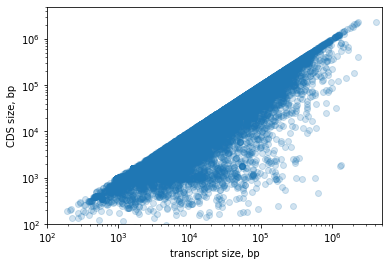

In [41]:
plt.scatter((ddd.loc[:,2] - ddd.loc[:,1]).values,(ddd.loc[:,11] - ddd.loc[:,10]).values,alpha=0.2)
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim((100,5e6))
ax.set_ylim((100,5e6))
ax.set_xlabel("transcript size, bp")
ax.set_ylabel("CDS size, bp")



In [55]:
ddd[ddd.iloc[:,5]=="+"]

0         1         2           3   4  5                6   \
0      chr1     11868     14362    DDX11L17   1  +  union_102725121   
1      chr1     11873     14409     DDX11L1   2  +  union_100287102   
7      chr1     30365     30503  MIR1302-11   2  +  union_100422919   
8      chr1     30365     30503  MIR1302-10   2  +  union_100422834   
9      chr1     30365     30503   MIR1302-9   2  +  union_100422831   
...     ...       ...       ...         ...  .. ..              ...   
24878  chrY  27874636  27879535      TTTY3B   1  +     union_474148   
24879  chrY  27874636  27879535       TTTY3   1  +     union_114760   
24880  chrY  59100402  59115125       SPRY3  20  +      union_10251   
24881  chrY  59214013  59276439       VAMP7  91  +       union_6845   
24882  chrY  59330366  59343488        IL9R  55  +       union_3581   

              7               8                                            9   \
0      102725121          pseudo  DEAD/H-box helicase 11 like 17 (pseudogene)   
1      100287102          pseudo   DEAD/H-box helicase 11 like 1 (pseudogene)   
7      100422919           ncRNA                             microRNA 1302-11   
8      100422834           ncRNA                             microRNA 1302-10   
9      100422831           ncRNA                              microRNA 1302-9   
...          ...             ...                                          ...   
24878     474148           ncRNA      testis-specific transcript, Y-linked 3B   
24879     114760           ncRNA       testis-specific transcript, Y-linked 3   
24880      10251  protein-coding           sprouty RTK signaling antagonist 3   
24881       6845  protein-coding        vesicle associated membrane protein 7   
24882       3581  protein-coding                       interleukin 9 receptor   

             10        11                                                 12  \
0         14362     14362                                  11868,12612,13220   
1         14409     14409                                  11873,12612,13220   
7         30503     30503                                              30365   
8         30503     30503                                              30365   
9         30503     30503                                              30365   
...         ...       ...                                                ...   
24878  27879535  27879535                         27874636,27876938,27879430   
24879  27879535  27879535                         27874636,27876938,27879430   
24880  59106539  59107406                                  59100402,59106433   
24881  59222135  59274621  59214013,59222126,59222126,59228291,59230781,5...   
24882  59330430  59343080  59330366,59334078,59335552,59335576,59336119,5...   

                                                      13  
0                                      12227,12721,14362  
1                                      12227,12721,14409  
7                                                  30503  
8                                                  30503  
9                                                  30503  
...                                                  ...  
24878                         27874740,27877073,27879535  
24879                         27874740,27877073,27879535  
24880                                  59100804,59115125  
24881  59214117,59222216,59222281,59228349,59230919,5...  
24882  59330458,59334179,59335690,59335690,59336231,5...  

[12635 rows x 14 columns]

In [63]:
ddd.iloc[:,8]=="protein-coding"

0         1         2          3   4  5                6          7   \
0      chr1     11868     14362   DDX11L17   1  +  union_102725121  102725121   
1      chr1     11873     14409    DDX11L1   2  +  union_100287102  100287102   
2      chr1     14361     29370     WASH7P   4  -     union_653635     653635   
3      chr1     17368     17436  MIR6859-4   2  -  union_103504738  103504738   
4      chr1     17368     17436  MIR6859-1   2  -  union_102466751  102466751   
...     ...       ...       ...        ...  .. ..              ...        ...   
24880  chrY  59100402  59115125      SPRY3  20  +      union_10251      10251   
24881  chrY  59214013  59276439      VAMP7  91  +       union_6845       6845   
24882  chrY  59330366  59343488       IL9R  55  +       union_3581       3581   
24883  chrY  59347234  59349501     WASIR1   1  -  union_100128260  100128260   
24884  chrY  59358328  59360854   DDX11L16   3  -     union_727856     727856   

                   8                                            9         10  \
0              pseudo  DEAD/H-box helicase 11 like 17 (pseudogene)     14362   
1              pseudo   DEAD/H-box helicase 11 like 1 (pseudogene)     14409   
2              pseudo            WASP family homolog 7, pseudogene     29370   
3               ncRNA                              microRNA 6859-4     17436   
4               ncRNA                              microRNA 6859-1     17436   
...               ...                                          ...       ...   
24880  protein-coding           sprouty RTK signaling antagonist 3  59106539   
24881  protein-coding        vesicle associated membrane protein 7  59222135   
24882  protein-coding                       interleukin 9 receptor  59330430   
24883           ncRNA                WASH and IL9R antisense RNA 1  59349501   
24884          pseudo  DEAD/H-box helicase 11 like 16 (pseudogene)  59360854   

             11                                                 12  \
0         14362                                  11868,12612,13220   
1         14409                                  11873,12612,13220   
2         29370  14361,14969,15795,16606,16857,17232,17605,1791...   
3         17436                                              17368   
4         17436                                              17368   
...         ...                                                ...   
24880  59107406                                  59100402,59106433   
24881  59274621  59214013,59222126,59222126,59228291,59230781,5...   
24882  59343080  59330366,59334078,59335552,59335576,59336119,5...   
24883  59349501                                  59347234,59349332   
24884  59360854                         59358328,59360006,59360500   

                                                      13  
0                                      12227,12721,14362  
1                                      12227,12721,14409  
2      14829,15038,15947,16765,17055,17368,17742,1806...  
3                                                  17436  
4                                                  17436  
...                                                  ...  
24880                                  59100804,59115125  
24881  59214117,59222216,59222281,59228349,59230919,5...  
24882  59330458,59334179,59335690,59335690,59336231,5...  
24883                                  59348296,59349501  
24884                         59359508,59360115,59360854  

[24885 rows x 14 columns]

In [69]:
ddd.loc[:,[1,2,10,11,5,8]]

1         2         10        11 5               8 
0         11868     14362     14362     14362  +          pseudo
1         11873     14409     14409     14409  +          pseudo
2         14361     29370     29370     29370  -          pseudo
3         17368     17436     17436     17436  -           ncRNA
4         17368     17436     17436     17436  -           ncRNA
...         ...       ...       ...       ... ..             ...
24880  59100402  59115125  59106539  59107406  +  protein-coding
24881  59214013  59276439  59222135  59274621  +  protein-coding
24882  59330366  59343488  59330430  59343080  +  protein-coding
24883  59347234  59349501  59349501  59349501  -           ncRNA
24884  59358328  59360854  59360854  59360854  -          pseudo

[24885 rows x 6 columns]

Text(0, 0.5, 'TSS--->CDS distance, bp')

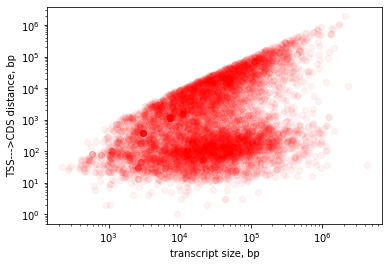

In [81]:
# 1---->2 # transcript coords
# 10-->11 # CDS coords
# bins = np.linspace(0,1e6,200)
# bins = np.geomspace(100,1e6,200)
y = (ddd.loc[:,10] - ddd.loc[:,1])[(ddd.iloc[:,5]=="+")&(ddd.iloc[:,8]=="protein-coding")].values
x = (ddd.loc[:,2] - ddd.loc[:,1])[(ddd.iloc[:,5]=="+")&(ddd.iloc[:,8]=="protein-coding")].values

plt.loglog(x,y,'ro',alpha=0.05)
ax = plt.gca()#.set_xscale("log")
# plt.gca().set_title("distribution of CDS")
ax.set_xlabel("transcript size, bp")
ax.set_ylabel("TSS--->CDS distance, bp")


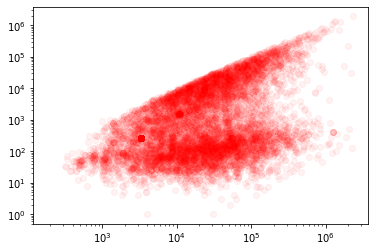

In [79]:
# 2---->1
# 11-->10
# bins = np.linspace(0,1e6,200)
# bins = np.geomspace(100,1e6,200)
y = (ddd.loc[:,2] - ddd.loc[:,11])[(ddd.iloc[:,5]=="-")&(ddd.iloc[:,8]=="protein-coding")].values
x = (ddd.loc[:,2] - ddd.loc[:,1])[(ddd.iloc[:,5]=="-")&(ddd.iloc[:,8]=="protein-coding")].values

plt.loglog(x,y,'ro',alpha=0.05)
# plt.gca().set_xscale("log")
# plt.gca().set_title("distribution of CDS")

<AxesSubplot:>

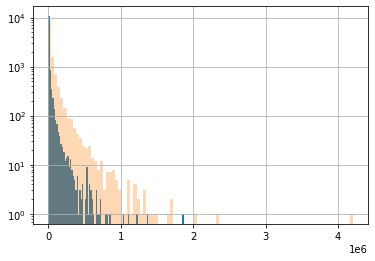

In [56]:
# bins = np.linspace(0,1e6,200)
# bins = np.geomspace(100,1e6,200)
(ddd.loc[:,10] - ddd.loc[:,1])[ddd.iloc[:,5]=="+"].hist(bins=100,log=True)
(ddd.loc[:,2] - ddd.loc[:,1])[ddd.iloc[:,5]=="+"].hist(bins=100,log=True,alpha=0.3)

# plt.gca().set_xscale("log")
# plt.gca().set_title("distribution of CDS")

Text(0.5, 1.0, 'distribution of CDS')

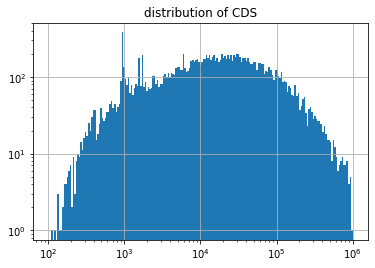

In [31]:
# bins = np.linspace(0,1e6,200)
bins = np.geomspace(100,1e6,200)
(ddd.loc[:,11] - ddd.loc[:,10]).hist(bins=bins,log=True)
plt.gca().set_xscale("log")
plt.gca().set_title("distribution of CDS")

### ends of the genes ... 3'-end of the genes ...

In [ ]:
aaa = ddd[ddd[8] == "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6]
# .to_csv("protein-coding-genes+.bed",index=False,header=None,sep="\t")
# aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

pcTSS1 = aaa[paaa].iloc[:,0:2].reset_index(drop=True).copy()
pcTSS1[2] = pcTSS1[1]+5
pcTSS1 = pcTSS1.drop_duplicates().reset_index(drop=True)
pcTSS1["strand"] = "+"


pcTSS2 = aaa[maaa].iloc[:,0:1].reset_index(drop=True).copy()
pcTSS2[1] = aaa[maaa].iloc[:,2].values-5
pcTSS2[2] = pcTSS2[1]+5
pcTSS2 = pcTSS2.drop_duplicates().reset_index(drop=True)
pcTSS2["strand"] = "-"

print(f"number of TSS+ {len(pcTSS1)}")
print(f"number of TSS- {len(pcTSS2)}")

##################################################
# non-coding now:

aaa = ddd[ddd[8] != "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")

ncTSS1 = aaa[paaa].iloc[:,0:2].reset_index(drop=True).copy()
ncTSS1[2] = ncTSS1[1]+5
ncTSS1 = ncTSS1.drop_duplicates().reset_index(drop=True)
ncTSS1["strand"] = "+"

ncTSS2 = aaa[maaa].iloc[:,0:1].reset_index(drop=True).copy()
ncTSS2[1] = aaa[maaa].iloc[:,2].values-5
ncTSS2[2] = ncTSS2[1]+5
ncTSS2 = ncTSS2.drop_duplicates().reset_index(drop=True)
ncTSS2["strand"] = "-"

print(f"number of TSS+ {len(ncTSS1)}")
print(f"number of TSS- {len(ncTSS2)}")


print(f"number of TSS protein coding {len(pcTSS1)}")
print(f"number of TSS non-coding {len(pcTSS1)}")
TSS1 = pd.concat([pcTSS1,ncTSS1]).reset_index(drop=True).drop_duplicates()
print(f"combined of TSS {len(TSS1)}, compare to {len(pcTSS1)+len(ncTSS1)}")
TSS1.reset_index(drop=True).to_csv("allTSSplus.bed",index=False,header=None,sep="\t")

print(f"number of TSS protein coding {len(pcTSS2)}")
print(f"number of TSS non-coding {len(pcTSS2)}")
TSS2 = pd.concat([pcTSS2,ncTSS2]).reset_index(drop=True).drop_duplicates()
print(f"combined of TSS {len(TSS2)}, compare to {len(pcTSS2)+len(ncTSS2)}")
TSS2.reset_index(drop=True).to_csv("allTSSminus.bed",index=False,header=None,sep="\t")



In [ ]:
#### to be continued ...

In [43]:
aaa = ddd[ddd[8] == "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6].to_csv("protein-coding-genes+.bed",index=False,header=None,sep="\t")
aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

In [44]:
# let's look at other types of transcripts separately !
aaa = ddd[ddd[8] != "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6].to_csv("noncoding-genes+.bed",index=False,header=None,sep="\t")
aaa[maaa].iloc[:,:6].to_csv("noncoding-genes-.bed",index=False,header=None,sep="\t")

In [45]:
! wc -l protein-coding-genes+.bed
! wc -l protein-coding-genes-.bed
! wc -l noncoding-genes+.bed
! wc -l noncoding-genes-.bed

8590 protein-coding-genes+.bed
8295 protein-coding-genes-.bed
4045 noncoding-genes+.bed
3955 noncoding-genes-.bed


In [120]:
! bedToBigBed -tab -type=bed6 protein-coding-genes+.bed hg19.sizes pcgene_plus.bb
! bedToBigBed -tab -type=bed6 protein-coding-genes-.bed hg19.sizes pcgene_minus.bb

pass1 - making usageList (24 chroms): 2 millis
pass2 - checking and writing primary data (8590 records, 6 fields): 16 millis
pass1 - making usageList (24 chroms): 2 millis
pass2 - checking and writing primary data (8295 records, 6 fields): 16 millis


In [15]:
! bedToBigBed -tab -type=bed6 noncoding-genes+.bed hg19.sizes ncgene_plus.bb
! bedToBigBed -tab -type=bed6 noncoding-genes-.bed hg19.sizes ncgene_minus.bb

pass1 - making usageList (24 chroms): 2 millis
pass2 - checking and writing primary data (4045 records, 6 fields): 12 millis
pass1 - making usageList (25 chroms): 1 millis
pass2 - checking and writing primary data (3955 records, 6 fields): 7 millis


### Let's create a putative list of TSSs as well - beginning of +-genes and ends of --genes ...

In [3]:
aaa = ddd[ddd[8] == "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6]
# .to_csv("protein-coding-genes+.bed",index=False,header=None,sep="\t")
# aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

TSS1 = aaa[paaa].iloc[:,0:2].reset_index(drop=True).copy()
TSS1[2] = TSS1[1]+5
TSS1 = TSS1.drop_duplicates().reset_index(drop=True)
TSS1["strand"] = "+"


TSS2 = aaa[maaa].iloc[:,0:1].reset_index(drop=True).copy()
TSS2[1] = aaa[maaa].iloc[:,2].values-5
TSS2[2] = TSS2[1]+5
TSS2 = TSS2.drop_duplicates().reset_index(drop=True)
TSS2["strand"] = "-"


print(f"number of TSS+ {len(TSS1)}")
print(f"number of TSS- {len(TSS2)}")


TSSpc = pd.concat([TSS1,TSS2]).reset_index(drop=True).drop_duplicates()

print(f"combined of TSS {len(TSSpc)}, compare to {len(TSS1)+len(TSS2)}")

TSSpc.reset_index(drop=True).to_csv("pc-TSS.bed",index=False,header=None,sep="\t")


number of TSS+ 8368
number of TSS- 8097
combined of TSS 16465, compare to 16465


In [87]:
ddd

0         1         2          3   4  5                6          7   \
0      chr1     11868     14362   DDX11L17   1  +  union_102725121  102725121   
1      chr1     11873     14409    DDX11L1   2  +  union_100287102  100287102   
2      chr1     14361     29370     WASH7P   4  -     union_653635     653635   
3      chr1     17368     17436  MIR6859-4   2  -  union_103504738  103504738   
4      chr1     17368     17436  MIR6859-1   2  -  union_102466751  102466751   
...     ...       ...       ...        ...  .. ..              ...        ...   
24880  chrY  59100402  59115125      SPRY3  20  +      union_10251      10251   
24881  chrY  59214013  59276439      VAMP7  91  +       union_6845       6845   
24882  chrY  59330366  59343488       IL9R  55  +       union_3581       3581   
24883  chrY  59347234  59349501     WASIR1   1  -  union_100128260  100128260   
24884  chrY  59358328  59360854   DDX11L16   3  -     union_727856     727856   

                   8                                            9         10  \
0              pseudo  DEAD/H-box helicase 11 like 17 (pseudogene)     14362   
1              pseudo   DEAD/H-box helicase 11 like 1 (pseudogene)     14409   
2              pseudo            WASP family homolog 7, pseudogene     29370   
3               ncRNA                              microRNA 6859-4     17436   
4               ncRNA                              microRNA 6859-1     17436   
...               ...                                          ...       ...   
24880  protein-coding           sprouty RTK signaling antagonist 3  59106539   
24881  protein-coding        vesicle associated membrane protein 7  59222135   
24882  protein-coding                       interleukin 9 receptor  59330430   
24883           ncRNA                WASH and IL9R antisense RNA 1  59349501   
24884          pseudo  DEAD/H-box helicase 11 like 16 (pseudogene)  59360854   

             11                                                 12  \
0         14362                                  11868,12612,13220   
1         14409                                  11873,12612,13220   
2         29370  14361,14969,15795,16606,16857,17232,17605,1791...   
3         17436                                              17368   
4         17436                                              17368   
...         ...                                                ...   
24880  59107406                                  59100402,59106433   
24881  59274621  59214013,59222126,59222126,59228291,59230781,5...   
24882  59343080  59330366,59334078,59335552,59335576,59336119,5...   
24883  59349501                                  59347234,59349332   
24884  59360854                         59358328,59360006,59360500   

                                                      13  
0                                      12227,12721,14362  
1                                      12227,12721,14409  
2      14829,15038,15947,16765,17055,17368,17742,1806...  
3                                                  17436  
4                                                  17436  
...                                                  ...  
24880                                  59100804,59115125  
24881  59214117,59222216,59222281,59228349,59230919,5...  
24882  59330458,59334179,59335690,59335690,59336231,5...  
24883                                  59348296,59349501  
24884                         59359508,59360115,59360854  

[24885 rows x 14 columns]

In [96]:
ddd[ddd.iloc[:,3].str.contains("UBC")]

0          1          2       3   4  5            6      7   \
6324   chr13   46908815   46964177  RUBCNL  24  -  union_80183  80183   
17178   chr3  197395737  197476570   RUBCN  50  -   union_9711   9711   

                   8                                9          10         11  \
6324   protein-coding  rubicon like autophagy enhancer   46917519   46946610   
17178  protein-coding      rubicon autophagy regulator  197401888  197444886   

                                                      12  \
6324   46908815,46915873,46918875,46919581,46923420,4...   
17178  197395737,197402292,197403755,197404350,197407...   

                                                      13  
6324   46917632,46917632,46918966,46919735,46923482,4...  
17178  197402067,197402386,197403909,197404412,197408...

In [6]:
aaa = ddd[ddd[8] != "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")

TSS1 = aaa[paaa].iloc[:,0:2].reset_index(drop=True).copy()
TSS1[2] = TSS1[1]+5
TSS1 = TSS1.drop_duplicates().reset_index(drop=True)
TSS1["strand"] = "+"

TSS2 = aaa[maaa].iloc[:,0:1].reset_index(drop=True).copy()
TSS2[1] = aaa[maaa].iloc[:,2].values-5
TSS2[2] = TSS2[1]+5
TSS2 = TSS2.drop_duplicates().reset_index(drop=True)
TSS2["strand"] = "-"

print(f"number of TSS+ {len(TSS1)}")
print(f"number of TSS- {len(TSS2)}")

TSSnc = pd.concat([TSS1,TSS2]).reset_index(drop=True).drop_duplicates()

print(f"combined of TSS {len(TSSnc)}, compare to {len(TSS1)+len(TSS2)}")

TSSnc.reset_index(drop=True).to_csv("nc-TSS.bed",index=False,header=None,sep="\t")


number of TSS+ 3823
number of TSS- 3602
combined of TSS 7425, compare to 7425


In [7]:
print(f"number of TSS protein coding {len(TSSpc)}")
print(f"number of TSS non-coding {len(TSSnc)}")
TSS = pd.concat([TSSpc,TSSnc]).reset_index(drop=True).drop_duplicates()
print(f"combined of TSS {len(TSS)}, compare to {len(TSSpc)+len(TSSnc)}")
TSS.reset_index(drop=True).to_csv("allTSS.bed",index=False,header=None,sep="\t")

number of TSS protein coding 16465
number of TSS non-coding 7425
combined of TSS 23871, compare to 23890


### List of TSSs by orientation ...

In [11]:
aaa = ddd[ddd[8] == "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6]
# .to_csv("protein-coding-genes+.bed",index=False,header=None,sep="\t")
# aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

pcTSS1 = aaa[paaa].iloc[:,0:2].reset_index(drop=True).copy()
pcTSS1[2] = pcTSS1[1]+5
pcTSS1 = pcTSS1.drop_duplicates().reset_index(drop=True)
pcTSS1["strand"] = "+"


pcTSS2 = aaa[maaa].iloc[:,0:1].reset_index(drop=True).copy()
pcTSS2[1] = aaa[maaa].iloc[:,2].values-5
pcTSS2[2] = pcTSS2[1]+5
pcTSS2 = pcTSS2.drop_duplicates().reset_index(drop=True)
pcTSS2["strand"] = "-"

print(f"number of TSS+ {len(pcTSS1)}")
print(f"number of TSS- {len(pcTSS2)}")

##################################################
# non-coding now:

aaa = ddd[ddd[8] != "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")

ncTSS1 = aaa[paaa].iloc[:,0:2].reset_index(drop=True).copy()
ncTSS1[2] = ncTSS1[1]+5
ncTSS1 = ncTSS1.drop_duplicates().reset_index(drop=True)
ncTSS1["strand"] = "+"

ncTSS2 = aaa[maaa].iloc[:,0:1].reset_index(drop=True).copy()
ncTSS2[1] = aaa[maaa].iloc[:,2].values-5
ncTSS2[2] = ncTSS2[1]+5
ncTSS2 = ncTSS2.drop_duplicates().reset_index(drop=True)
ncTSS2["strand"] = "-"

print(f"number of TSS+ {len(ncTSS1)}")
print(f"number of TSS- {len(ncTSS2)}")


print(f"number of TSS protein coding {len(pcTSS1)}")
print(f"number of TSS non-coding {len(pcTSS1)}")
TSS1 = pd.concat([pcTSS1,ncTSS1]).reset_index(drop=True).drop_duplicates()
print(f"combined of TSS {len(TSS1)}, compare to {len(pcTSS1)+len(ncTSS1)}")
TSS1.reset_index(drop=True).to_csv("allTSSplus.bed",index=False,header=None,sep="\t")

print(f"number of TSS protein coding {len(pcTSS2)}")
print(f"number of TSS non-coding {len(pcTSS2)}")
TSS2 = pd.concat([pcTSS2,ncTSS2]).reset_index(drop=True).drop_duplicates()
print(f"combined of TSS {len(TSS2)}, compare to {len(pcTSS2)+len(ncTSS2)}")
TSS2.reset_index(drop=True).to_csv("allTSSminus.bed",index=False,header=None,sep="\t")



number of TSS+ 8368
number of TSS- 8097
number of TSS+ 3823
number of TSS- 3602
number of TSS protein coding 8368
number of TSS non-coding 8368
combined of TSS 12180, compare to 12191
number of TSS protein coding 8097
number of TSS non-coding 8097
combined of TSS 11691, compare to 11699


### let's merge TSS with G4 peaks to defin all G4/transcription related locations ...

In [49]:
# bf is short for bioframe here ...
df = bioframe.read_table(
    "G4-Mao-sort",
    names=["chrom","start","end"]
)
df = df.sort_values(["chrom","start"])
df = df.reset_index(drop=True)
print(f"G4 ChipSeq peaks {len(df)}")
# bf is short for bioframe here ...
_df = pd.concat([TSS.rename({0:"chrom",1:"start",2:"end"},axis=1),df]).sort_values(["chrom","start"]).reset_index(drop=True)
bioframe.merge(_df, min_dist=1000)[["chrom","start","end"]].to_csv("union_G4_TSS.bed",header=None,index=False,sep="\t")
print(f"and the union list is {len(_df)} bs {len(df)+len(TSS)}")


G4 ChipSeq peaks 8955
and the union list is 32826 bs 32826


In [91]:
tss = TSS.rename({0:"chrom",1:"start",2:"end"},axis=1).copy()
# iii = np.arange(len(tss))
# np.random.shuffle(iii)
# tss.index = iii
# tss


In [93]:
bioframe.merge(tss, min_dist=10000)

chrom     start       end  n_intervals
0      chr1     11868     17436            3
1      chr1     29365     36081            3
2      chr1     69090     69095            1
3      chr1    323891    323896            1
4      chr1    367658    367663            1
...     ...       ...       ...          ...
18704  chrY  59100402  59100407            1
18705  chrY  59214013  59214018            1
18706  chrY  59330366  59330371            1
18707  chrY  59349496  59349501            1
18708  chrY  59360849  59360854            1

[18709 rows x 4 columns]

In [87]:
# bioframe.merge?
bioframe.merge(tss, min_dist=10000)

chrom     start       end  n_intervals
0      chr1     11868     17436            3
1      chr1     29365     36081            3
2      chr1     69090     69095            1
3      chr1    323891    323896            1
4      chr1    367658    367663            1
...     ...       ...       ...          ...
18704  chrY  59100402  59100407            1
18705  chrY  59214013  59214018            1
18706  chrY  59330366  59330371            1
18707  chrY  59349496  59349501            1
18708  chrY  59360849  59360854            1

[18709 rows x 4 columns]

In [69]:
bioframe.overlap(df,tss)

chrom_1    start_1      end_1 chrom_2 start_2   end_2
0       chr1     713977     714310    chr1  714009  714014
1       chr1     762850     762982    chr1  762897  762902
2       chr1     762850     762982    chr1  762970  762975
3       chr1     935414     935699    chr1  935472  935477
4       chr1     994963     995114    chr1  995113  995118
...      ...        ...        ...     ...     ...     ...
9299    chrX  153775453  153775729    <NA>    <NA>    <NA>
9300    chrX  154255314  154255500    <NA>    <NA>    <NA>
9301    chrY   10033450   10033615    <NA>    <NA>    <NA>
9302    chrY   10037740   10037912    <NA>    <NA>    <NA>
9303    chrY   13488805   13488945    <NA>    <NA>    <NA>

[9304 rows x 6 columns]

In [70]:
!head union_G4_TSS.bed

chr1	11868	11878
chr1	17431	17436
chr1	29365	30370
chr1	36076	36081
chr1	69090	69095
chr1	323891	323896
chr1	367658	367663
chr1	564384	564389
chr1	568060	568065
chr1	622029	622034


In [38]:
! bedSort {DATADIR}/{ASSEMBLY}/geneAnnotationsExonUnions.bed geneAnnotationsExonUnions.bed

In [65]:
! cat geneAnnotationsExonUnions.bed |cut -f1-4 > justGenes.bed

In [90]:
! bedToBigBed -tab -type=bed4 justGenes.bed hg19.sizes hg19_annot.bb! head -3000 geneAnnotationsExonUnions.bed|tail

chr10	70173820	70231878	DNA2	55	-	union_1763	1763	protein-coding	DNA replication helicase/nuclease 2	70174795	70231621	70173820,70176463,70178790,70179559,70181981,70182271,70182453,70190192,70190192,70191613,70191962,70192150,70196767,70202673,70204677,70206052,70209784,70218860,70225423,70227879,70229737,70231547,70231547,70231810	70174862,70176612,70178970,70179649,70182186,70182361,70182647,70190297,70190412,70191728,70192072,70192267,70196998,70202868,70204840,70206170,70210004,70218992,70225569,70228063,70229920,70231642,70231730,70231878
chr10	70320093	70454242	TET1	164	+	union_80312	80312	protein-coding	tet methylcytosine dioxygenase 1	70332095	70451571	70320093,70331973,70360737,70404454,70411602,70412257,70426801,70432651,70441155,70442592,70446112,70450564	70320499,70334009,70360791,70406762,70411693,70412351,70427013,70432802,70441245,70442730,70446464,70454242
chr10	70480995	70552134	CCAR1	94	+	union_55749	55749	protein-coding	cell division cycle and apoptosis regulator 1	

In [66]:
! head justGenes.bed

chr1	11868	14362	DDX11L17
chr1	11873	14409	DDX11L1
chr1	14361	29370	WASH7P
chr1	17368	17436	MIR6859-4
chr1	17368	17436	MIR6859-1
chr1	17368	17436	MIR6859-3
chr1	17368	17436	MIR6859-2
chr1	30365	30503	MIR1302-11
chr1	30365	30503	MIR1302-10
chr1	30365	30503	MIR1302-9


In [67]:
! bedToBigBed -tab -type=bed4 justGenes.bed hg19.sizes hg19_annot.bb

pass1 - making usageList (25 chroms): 7 millis
pass2 - checking and writing primary data (24885 records, 4 fields): 40 millis


In [68]:
ls -lah hg19*

-rw-rw-r-- 1 sergpolly sergpolly 418K Mar 25 18:32 hg19_annot.bb
-rwxrwxr-x 1 sergpolly sergpolly  376 Mar 25 17:35 hg19.reduced.chrom.sizes*
-rw-rw-r-- 1 sergpolly sergpolly 2.0K Mar 25 17:54 hg19.sizes


In [42]:
#wget http://hgdownload.cse.ucsc.edu/admin/exe/linux.x86_64/bedToBigBed

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *

In [70]:
bbi.info("hg19_annot.bb")

{'version': 4,
 'isCompressed': True,
 'isSwapped': 0,
 'primaryDataSize': 299451,
 'zoomLevels': 6,
 'chromCount': 25,
 'summary': {'basesCovered': 1157192927,
  'sum': 1246306033.0,
  'mean': 1.077007994017924,
  'min': 1.0,
  'max': 21.0,
  'std': 0.4987228052953744}}

In [115]:
bbi.fetch_intervals("hg19_annot.bb","chr1",40_000_000,40_200_000,iterator=False)

chrom     start       end    name  score strand
0  chr1  40026489  40042462  PABPC4      1      -
1  chr1  40089106  40105315    HEYL      1      -
2  chr1  40124792  40137710  NT5C1A      1      -
3  chr1  40144319  40157157  HPCAL4      1      -

In [114]:
bbi.fetch_intervals?

In [113]:
bbi.info("hg19_annot.bb")

{'version': 4,
 'isCompressed': True,
 'isSwapped': 0,
 'primaryDataSize': 212267,
 'zoomLevels': 5,
 'chromCount': 24,
 'summary': {'basesCovered': 1009255353,
  'sum': 1062351689.0,
  'mean': 1.052609417272023,
  'min': 1.0,
  'max': 21.0,
  'std': 0.45984559662229113}}

In [111]:
# bbi.fetch?
xxx = bbi.fetch(
    "hg19_annot.bb",
    "chr1",
    40_000_000,
    40_200_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)


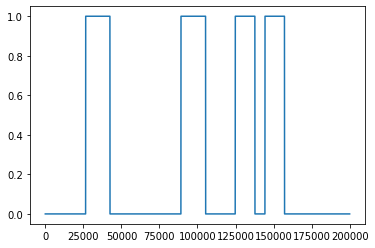

In [112]:
plt.plot(xxx)

In [77]:
!pwd

/home/sergpolly/Desktop/ALV-repo


In [8]:
! scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/for-higlass/AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all_select_hg19.txt ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/for-higlass/S44_NT_S442_IAA.output_events_all_select_hg19.txt ./

AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all 100%   79KB 825.7KB/s   00:00    
S44_NT_S442_IAA.output_events_all_select_hg19 100%   48KB 533.7KB/s   00:00    


In [ ]:
! bedSort {DATADIR}/{ASSEMBLY}/geneAnnotationsExonUnions.bed geneAnnotationsExonUnions.bed

In [14]:
! bedToBigBed

bedToBigBed v. 2.8 - Convert bed file to bigBed. (bbi version: 4)
usage:
   bedToBigBed in.bed chrom.sizes out.bb
Where in.bed is in one of the ascii bed formats, but not including track lines
and chrom.sizes is a two-column file/URL: <chromosome name> <size in bases>
and out.bb is the output indexed big bed file.
If the assembly <db> is hosted by UCSC, chrom.sizes can be a URL like
  http://hgdownload.soe.ucsc.edu/goldenPath/<db>/bigZips/<db>.chrom.sizes
or you may use the script fetchChromSizes to download the chrom.sizes file.
If you have bed annotations on patch sequences from NCBI, a more inclusive
chrom.sizes file can be found using a URL like
  http://hgdownload.soe.ucsc.edu/goldenPath/<db>/database/chromInfo.txt.gz
If not hosted by UCSC, a chrom.sizes file can be generated by running
twoBitInfo on the assembly .2bit file.
The in.bed file must be sorted by chromosome,start,
  to sort a bed file, use the unix sort command:
     sort -k1,1 -k2,2n unsorted.bed > sorted.bed
Sorting 

In [15]:
! bedSort AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all_select_hg19.txt SpliceDDX55aux.bed
! bedSort S44_NT_S442_IAA.output_events_all_select_hg19.txt SpliceCTCFaux.bed

In [16]:
! bedToBigBed -tab -type=bed3 SpliceDDX55aux.bed hg19.sizes SpliceDDX55aux.bb
! bedToBigBed -tab -type=bed3 SpliceCTCFaux.bed hg19.sizes SpliceCTCFaux.bb

pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (3410 records, 3 fields): 5 millis
pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (2079 records, 3 fields): 4 millis


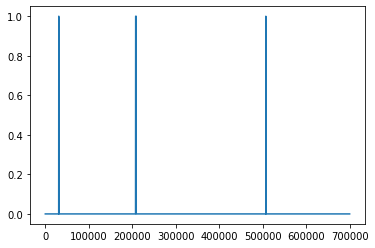

In [24]:
# bbi.fetch?
xxx = bbi.fetch(
    "SpliceDDX55aux.bb",
    "chr1",
    40_000_000,
    40_700_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)
plt.plot(xxx)

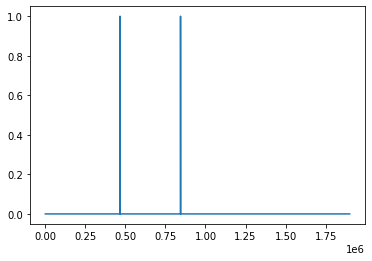

In [27]:
# bbi.fetch?
xxx = bbi.fetch(
    "SpliceCTCFaux.bb",
    "chr1",
    39_000_000,
    40_900_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)
plt.plot(xxx)